# Grok Recruiter - Taste-Graph Talent Discovery

This notebook walks through each phase of the discovery pipeline:

1. **Setup** - Load config and initialize clients
2. **Phase 1** - Resolve seed accounts (xAI employees)
3. **Phase 2** - Expand graph (following > likes > retweets > replies)
4. **Phase 3** - Hydrate user profiles & filter candidates
5. **Phase 4a** - Fast LLM screening (bio + pinned tweet)
6. **Phase 4b** - Full Grok evaluation (all tweets)
7. **Phase 5** - Rank & export results

## Setup - Load Config & Initialize Clients

In [26]:
import sys
from pathlib import Path

import yaml
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Import our modules
from src.x_client import XClient
from src.grok_client import GrokClient, load_criteria
from src.graph_builder import GraphBuilder, Node, Edge
from src.evaluator import CandidateEvaluator, PreFilterResult, print_evaluation_summary
from src.ranking import compute_rankings, export_ranked_nodes

print("Modules loaded successfully!")

Modules loaded successfully!


In [27]:
# Load configuration
CONFIG_PATH = "seeds.yaml"
CRITERIA_PATH = "criteria.yaml"
CACHE_DIR = "data/raw"
EVAL_CACHE_DIR = "data/evaluations"
OUTPUT_DIR = "data/processed"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

roots = config.get("roots", [])
settings = config.get("settings", {})

print(f"Loaded {len(roots)} seed accounts")
print(f"Settings: {settings}")

Loaded 90 seed accounts
Settings: {'max_depth': 1, 'max_followers_candidate': 50000, 'min_followers_candidate': 50, 'max_following_per_root': 500, 'max_liked_tweets': 100, 'max_root_tweets': 50, 'max_likers_per_tweet': 100, 'max_retweeters_per_tweet': 100, 'max_replies_per_conversation': 50}


In [28]:
# Initialize X API client
x_client = XClient(cache_dir=CACHE_DIR)
print("X API client initialized")

# Initialize Grok client
grok_client = GrokClient(cache_dir=EVAL_CACHE_DIR)
print("Grok client initialized")
print(f"  Fast model: {grok_client.fast_model}")
print(f"  Full model: {grok_client.model}")

X API client initialized
Grok client initialized
  Fast model: grok-4-1-fast-non-reasoning
  Full model: grok-4-1-fast-reasoning


## Phase 1 - Resolve Seed Accounts

Convert seed handles to user objects with IDs and metadata.

**No LLM calls** - just X API

In [29]:
# Initialize graph builder
builder = GraphBuilder(
    x_client=x_client,
    roots=roots,
    settings=settings,
)

print(f"Graph builder initialized with {len(roots)} roots")

Graph builder initialized with 90 roots


In [30]:
# Phase 1: Resolve root accounts
print("=" * 60)
print("PHASE 1: Resolving root accounts")
print("=" * 60)

root_users = {}

for handle in roots:
    user = x_client.get_user_by_username(handle)
    if not user:
        print(f"  [warn] Could not resolve @{handle}")
        continue
    
    root_users[handle] = user
    builder._add_or_update_node(user, is_root=True)
    followers = user.get('public_metrics', {}).get('followers_count', 0)
    print(f"  [root] @{handle} (ID: {user['id']}, followers: {followers:,})")

print(f"\nResolved {len(root_users)}/{len(roots)} root accounts")

PHASE 1: Resolving root accounts
  Fetching user: @elonmusk
  [cache] Loading from user_elonmusk.json
  [root] @elonmusk (ID: 44196397, followers: 229,420,382)
  Fetching user: @A5_Wagyu
  [cache] Loading from user_A5_Wagyu.json
  [root] @A5_Wagyu (ID: 265152280, followers: 409)
  Fetching user: @APrerepa
  [cache] Loading from user_APrerepa.json
  [root] @APrerepa (ID: 1146180676091170817, followers: 2,254)
  Fetching user: @AdamSliwakowski
  [cache] Loading from user_AdamSliwakowski.json
  [root] @AdamSliwakowski (ID: 1513813650, followers: 371)
  Fetching user: @a2xai
  [cache] Loading from user_a2xai.json
  [root] @a2xai (ID: 1173974870, followers: 2,081)
  Fetching user: @adityagupta
  [cache] Loading from user_adityagupta.json
  [root] @adityagupta (ID: 2269061347, followers: 7,935)
  Fetching user: @aknowntheory
  [cache] Loading from user_aknowntheory.json
  [root] @aknowntheory (ID: 630619183, followers: 516)
  Fetching user: @Alexjpeng
  [cache] Loading from user_Alexjpeng.js

## Phase 2 - Expand Graph

Expand from seeds using priority order:
1. **Following** (weight 5.0) - Who seeds chose to follow
2. **Retweets** (weight 3.0) - Who retweeted seed tweets
3. **Replies** (weight 2.5) - Who replied to seed tweets

**Note:** Likes endpoint not available on Free/Basic X API tier (skipped)

**No LLM calls** - just X API

In [31]:
# Phase 2a: Expand via FOLLOWING (strongest signal)
# Processing ALL seeds (not just first 5)
print("=" * 60)
print("PHASE 2a: Expanding via FOLLOWING (strongest signal)")
print("=" * 60)

for handle, root_user in root_users.items():  # ALL seeds
    root_id = root_user["id"]
    print(f"\n[root] @{handle} - fetching following...")
    builder._expand_following(root_id)

print(f"\nNodes so far: {len(builder.nodes)}")
print(f"Edges so far: {len(builder.edges)}")

PHASE 2a: Expanding via FOLLOWING (strongest signal)

[root] @elonmusk - fetching following...
  Fetching following for user 44196397
  [cache] Loading from following_44196397_page0.json
    Found 500 accounts followed
  [following] Processing 500 accounts followed by root

[root] @A5_Wagyu - fetching following...
  Fetching following for user 265152280
  [cache] Loading from following_265152280_page0.json
    Found 480 accounts followed
  [following] Processing 480 accounts followed by root

[root] @APrerepa - fetching following...
  Fetching following for user 1146180676091170817
  [cache] Loading from following_1146180676091170817_page0.json
    Found 378 accounts followed
  [following] Processing 378 accounts followed by root

[root] @AdamSliwakowski - fetching following...
  Fetching following for user 1513813650
  [cache] Loading from following_1513813650_page0.json
    Found 491 accounts followed
  [following] Processing 491 accounts followed by root

[root] @a2xai - fetching fo

In [32]:
# Phase 2c: Expand via ROOT TWEETS (retweets, replies)
# Processing ALL seeds
print("=" * 60)
print("PHASE 2c: Expanding via ROOT TWEETS (retweets, replies)")
print("=" * 60)

for handle, root_user in root_users.items():  # ALL seeds
    root_id = root_user["id"]
    print(f"\n[root] @{handle} - fetching tweet engagements...")
    builder._expand_root_tweets(root_id)

print(f"\nNodes so far: {len(builder.nodes)}")
print(f"Edges so far: {len(builder.edges)}")

PHASE 2c: Expanding via ROOT TWEETS (retweets, replies)

[root] @elonmusk - fetching tweet engagements...
  Fetching tweets for user 44196397
  [cache] Loading from tweets_44196397.json
    Found 50 tweets
  [cache] Loading from retweeters_1997513976012517736.json
  [cache] Loading from replies_1997513976012517736.json
  [cache] Loading from retweeters_1997513859255660654.json
  [cache] Loading from replies_1997513859255660654.json
  [cache] Loading from retweeters_1997511219591491938.json
  [cache] Loading from replies_1997511219591491938.json

[root] @A5_Wagyu - fetching tweet engagements...
  Fetching tweets for user 265152280
  [cache] Loading from tweets_265152280.json
    Found 8 tweets
  [cache] Loading from retweeters_1478450277636132865.json
  [cache] Loading from replies_1478450277636132865.json
  [cache] Loading from retweeters_1433652701041029123.json
  [cache] Loading from replies_1433652701041029123.json
  [cache] Loading from retweeters_1429923686966956042.json
  [cache]

KeyboardInterrupt: 

# Phase 2c: Expand via ROOT TWEETS (retweets, replies)
# This phase is OPTIONAL - following data (Phase 2a) is the strongest signal
# Skip this if hitting rate limits

ENABLE_PHASE_2C = False  # Set to True to enable (will hit rate limits with 90 seeds)

if ENABLE_PHASE_2C:
    print("=" * 60)
    print("PHASE 2c: Expanding via ROOT TWEETS (retweets, replies)")
    print("=" * 60)
    
    for handle, root_user in root_users.items():
        root_id = root_user["id"]
        print(f"\n[root] @{handle} - fetching tweet engagements...")
        builder._expand_root_tweets(root_id)
    
    print(f"\nNodes so far: {len(builder.nodes)}")
    print(f"Edges so far: {len(builder.edges)}")
else:
    print("=" * 60)
    print("PHASE 2c: SKIPPED (rate limit protection)")
    print("=" * 60)
    print("  [info] Following data from Phase 2a is the strongest signal")
    print("  [info] Set ENABLE_PHASE_2C = True to enable retweet/reply expansion")
    print(f"\nNodes so far: {len(builder.nodes)}")
    print(f"Edges so far: {len(builder.edges)}")

In [33]:
# Phase 3: Hydrate pending users
print("=" * 60)
print("PHASE 3: Hydrating discovered users")
print("=" * 60)

builder._hydrate_pending_users()

# Count results
total_nodes = len(builder.nodes)
total_edges = len(builder.edges)
root_count = sum(1 for n in builder.nodes.values() if n.is_root)
candidate_count = sum(1 for n in builder.nodes.values() if n.is_candidate)

# Edge breakdown
edge_counts = {}
for edge in builder.edges:
    edge_counts[edge.interaction_type] = edge_counts.get(edge.interaction_type, 0) + 1

print(f"\n" + "=" * 60)
print("DISCOVERY COMPLETE (Phase 1-3)")
print("=" * 60)
print(f"  Total nodes: {total_nodes:,}")
print(f"  Total edges: {total_edges:,}")
print(f"  Root accounts: {root_count}")
print(f"  Candidate accounts: {candidate_count:,}")
print(f"  Edge breakdown: {edge_counts}")

PHASE 3: Hydrating discovered users

[hydrate] Fetching details for 192 users...
  Hydrating 100 users (batch 1)
  Hydrating 92 users (batch 2)
[hydrate] Updated 192 user profiles

DISCOVERY COMPLETE (Phase 1-3)
  Total nodes: 16,811
  Total edges: 28,709
  Root accounts: 89
  Candidate accounts: 11,559
  Edge breakdown: {'follow': 27266, 'retweet': 1151, 'reply': 292}


In [34]:
# Phase 3b: Multi-depth expansion (up to depth 5)
# Iteratively expand from top candidates at each depth level
#
# Strategy:
#   - At each depth, find top candidates (most followed by previous level)
#   - Fetch who THEY follow
#   - Continue until max_depth or no new candidates found

MAX_DEPTH = 5           # Go up to 5 hops from seeds
TOP_K_PER_DEPTH = 30    # Expand from top 30 candidates at each depth
MAX_FOLLOWING = 100     # Fetch up to 100 accounts each follows

print("=" * 60)
print(f"MULTI-DEPTH EXPANSION (up to depth {MAX_DEPTH})")
print("=" * 60)

for depth in range(2, MAX_DEPTH + 1):
    print(f"\n{'='*40}")
    print(f"DEPTH {depth}")
    print(f"{'='*40}")
    
    # Find candidates from previous depth with highest in-degree
    prev_depth_tag = f"depth{depth-1}_following" if depth > 2 else "followed_by_root"
    
    # For depth 2, look at follow edges from seeds (depth=1)
    # For depth 3+, look at edges from previous depth level
    candidate_scores = {}
    
    for edge in builder.edges:
        if edge.interaction_type == "follow" and edge.depth == depth - 1:
            dst = edge.dst_user_id
            if dst in builder.nodes and builder.nodes[dst].is_candidate:
                candidate_scores[dst] = candidate_scores.get(dst, 0) + 1
    
    if not candidate_scores:
        print(f"  No candidates with incoming edges at depth {depth-1}, stopping expansion")
        break
    
    # Sort by score and take top k
    top_candidates = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_K_PER_DEPTH]
    
    print(f"  Expanding from top {len(top_candidates)} depth-{depth-1} candidates")
    
    new_discoveries = 0
    
    for user_id, score in top_candidates:
        node = builder.nodes.get(user_id)
        if not node:
            continue
        
        # Get who this candidate follows
        following = builder.x.get_user_following(user_id, max_results=MAX_FOLLOWING)
        
        for user in following:
            fol_id = user.get("id")
            if not fol_id or fol_id == user_id:
                continue
            
            # Skip if already in graph
            if fol_id in builder.nodes:
                continue
            
            # Add new node
            new_node = builder._add_or_update_node(user, discovered_via=f"depth{depth}_following")
            if new_node:
                new_discoveries += 1
                
                # Add edge with current depth
                builder._add_edge(
                    src_user_id=user_id,
                    dst_user_id=fol_id,
                    interaction_type="follow",
                    tweet_id="",
                    created_at="",
                    depth=depth,
                )
    
    print(f"  Discovered {new_discoveries} new accounts at depth {depth}")
    
    # Hydrate new users
    if new_discoveries > 0:
        builder._hydrate_pending_users()
    else:
        print(f"  No new discoveries at depth {depth}, stopping expansion")
        break

# Final summary
print(f"\n{'='*60}")
print("MULTI-DEPTH EXPANSION COMPLETE")
print(f"{'='*60}")
print(f"  Total nodes: {len(builder.nodes):,}")
print(f"  Total edges: {len(builder.edges):,}")

# Count by depth
depth_counts = {}
for node in builder.nodes.values():
    via = node.discovered_via
    if via.startswith("depth") and via.endswith("_following"):
        d = via.replace("depth", "").replace("_following", "")
        depth_counts[f"depth_{d}"] = depth_counts.get(f"depth_{d}", 0) + 1
    elif via == "followed_by_root":
        depth_counts["depth_1"] = depth_counts.get("depth_1", 0) + 1
    elif via in ["retweeted_root", "replied_to_root"]:
        depth_counts["depth_1_engagement"] = depth_counts.get("depth_1_engagement", 0) + 1

for d, count in sorted(depth_counts.items()):
    print(f"  {d}: {count:,} candidates")

MULTI-DEPTH EXPANSION (up to depth 5)

DEPTH 2
  Expanding from top 30 depth-1 candidates
  Fetching following for user 1588323862110162944
  [cache] Loading from following_1588323862110162944_page0.json
    Found 100 accounts followed
  Fetching following for user 137463715
  [cache] Loading from following_137463715_page0.json
    Found 100 accounts followed
  Fetching following for user 881959726958862337
    Found 100 accounts followed
  Fetching following for user 1260917258970451969
  [cache] Loading from following_1260917258970451969_page0.json
    Found 100 accounts followed
  Fetching following for user 1219282049070063617
  [cache] Loading from following_1219282049070063617_page0.json
    Found 100 accounts followed
  Fetching following for user 1838355640890331137
    Found 100 accounts followed
  Fetching following for user 1058927125
  [cache] Loading from following_1058927125_page0.json
    Found 100 accounts followed
  Fetching following for user 3086182267
  [cache] Load

# Phase 3b: Multi-depth expansion (up to depth 5)
# Iteratively expand from top candidates at each depth level
#
# Strategy:
#   - At each depth, find top candidates (most followed by previous level)
#   - Fetch who THEY follow
#   - Continue until max_depth or no new candidates found
#
# RATE LIMIT AWARE: Reduced parameters to stay under API limits

MAX_DEPTH = 5           # Go up to 5 hops from seeds
TOP_K_PER_DEPTH = 15    # Expand from top 15 candidates at each depth (reduced from 30)
MAX_FOLLOWING = 50      # Fetch up to 50 accounts each follows (reduced from 100)

print("=" * 60)
print(f"MULTI-DEPTH EXPANSION (up to depth {MAX_DEPTH})")
print("=" * 60)
print(f"  Config: top_k={TOP_K_PER_DEPTH}, max_following={MAX_FOLLOWING}")

for depth in range(2, MAX_DEPTH + 1):
    print(f"\n{'='*40}")
    print(f"DEPTH {depth}")
    print(f"{'='*40}")
    
    # Find candidates from previous depth with highest in-degree
    candidate_scores = {}
    
    for edge in builder.edges:
        if edge.interaction_type == "follow" and edge.depth == depth - 1:
            dst = edge.dst_user_id
            if dst in builder.nodes and builder.nodes[dst].is_candidate:
                candidate_scores[dst] = candidate_scores.get(dst, 0) + 1
    
    if not candidate_scores:
        print(f"  No candidates with incoming edges at depth {depth-1}, stopping expansion")
        break
    
    # Sort by score and take top k
    top_candidates = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_K_PER_DEPTH]
    
    print(f"  Expanding from top {len(top_candidates)} depth-{depth-1} candidates")
    
    new_discoveries = 0
    
    for user_id, score in top_candidates:
        node = builder.nodes.get(user_id)
        if not node:
            continue
        
        print(f"    @{node.handle} (score: {score})...", end=" ")
        
        # Get who this candidate follows
        following = builder.x.get_user_following(user_id, max_results=MAX_FOLLOWING)
        
        added = 0
        for user in following:
            fol_id = user.get("id")
            if not fol_id or fol_id == user_id:
                continue
            
            # Skip if already in graph
            if fol_id in builder.nodes:
                continue
            
            # Add new node
            new_node = builder._add_or_update_node(user, discovered_via=f"depth{depth}_following")
            if new_node:
                new_discoveries += 1
                added += 1
                
                # Add edge with current depth
                builder._add_edge(
                    src_user_id=user_id,
                    dst_user_id=fol_id,
                    interaction_type="follow",
                    tweet_id="",
                    created_at="",
                    depth=depth,
                )
        
        print(f"+{added} new")
    
    print(f"\n  Total discovered at depth {depth}: {new_discoveries}")
    
    # Hydrate new users
    if new_discoveries > 0:
        builder._hydrate_pending_users()
    else:
        print(f"  No new discoveries at depth {depth}, stopping expansion")
        break

# Final summary
print(f"\n{'='*60}")
print("MULTI-DEPTH EXPANSION COMPLETE")
print(f"{'='*60}")
print(f"  Total nodes: {len(builder.nodes):,}")
print(f"  Total edges: {len(builder.edges):,}")

# Count by depth
depth_counts = {}
for node in builder.nodes.values():
    via = node.discovered_via
    if via.startswith("depth") and via.endswith("_following"):
        d = via.replace("depth", "").replace("_following", "")
        depth_counts[f"depth_{d}"] = depth_counts.get(f"depth_{d}", 0) + 1
    elif via == "followed_by_root":
        depth_counts["depth_1"] = depth_counts.get("depth_1", 0) + 1
    elif via in ["retweeted_root", "replied_to_root"]:
        depth_counts["depth_1_engagement"] = depth_counts.get("depth_1_engagement", 0) + 1

print("\nCandidate breakdown by depth:")
for d, count in sorted(depth_counts.items()):
    print(f"  {d}: {count:,}")

In [36]:
# Prepare candidates for evaluation
# Priority: followed_by_root > liked_by_root > retweeted_root > replied_to_root
discovery_priority = {
    "followed_by_root": 0,
    "liked_by_root": 1,
    "retweeted_root": 2,
    "replied_to_root": 3,
    "liked_root_tweet": 4,
}

candidates = [
    {
        "user_id": node.user_id,
        "handle": node.handle,
        "bio": node.bio,
        "followers_count": node.followers_count,
        "tweet_count": node.tweet_count,
        "discovered_via": node.discovered_via,
    }
    for node in builder.nodes.values()
    if node.is_candidate
]

# Sort by discovery priority
candidates.sort(key=lambda c: discovery_priority.get(c.get("discovered_via", ""), 99))

print(f"Prepared {len(candidates):,} candidates for evaluation")
print(f"\nDiscovery method breakdown:")
discovery_counts = {}
for c in candidates:
    via = c.get("discovered_via", "unknown")
    discovery_counts[via] = discovery_counts.get(via, 0) + 1
for via, count in sorted(discovery_counts.items(), key=lambda x: discovery_priority.get(x[0], 99)):
    print(f"  {via}: {count:,}")

Prepared 16,409 candidates for evaluation

Discovery method breakdown:
  followed_by_root: 10,694
  retweeted_root: 707
  replied_to_root: 158
  depth2_following: 576
  depth3_following: 1,218
  depth4_following: 1,399
  depth5_following: 1,657


In [37]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

def visualize_graph(builder: GraphBuilder, max_nodes: int = 500, interaction_filter: list = None, 
                    layout: str = "spring", show_labels: bool = False):
    '''
    Visualize the graph showing different connection types.
    
    Args:
        builder: GraphBuilder instance with nodes and edges
        max_nodes: Maximum number of nodes to display (for performance)
        interaction_filter: List of interaction types to show (e.g., ['retweet', 'reply'])
                          If None, shows all types
        layout: Layout algorithm ('spring', 'kamada_kawai', 'circular')
        show_labels: Whether to show node labels (can be slow for large graphs)
    '''
    G = nx.DiGraph()
    
    edge_type_colors = {
        'follow': '#1DA1F2',    # Twitter blue
        'retweet': '#17BF63',   # Green 
        'reply': '#FFAD1F',     # Orange
        'like': '#E0245E',      # Red/pink
        'quote': '#794BC4'      # Purple
    }
    
    edge_type_widths = {
        'follow': 2.0,
        'retweet': 1.5,
        'reply': 1.2,
        'like': 0.8,
        'quote': 1.0
    }
    
    root_ids = {n.user_id for n in builder.nodes.values() if n.is_root}
    
    # Build full graph first
    for edge in builder.edges:
        if interaction_filter and edge.interaction_type not in interaction_filter:
            continue
        G.add_edge(edge.src_user_id, edge.dst_user_id, 
                   interaction_type=edge.interaction_type, weight=edge.weight)
    
    # Add node attributes
    for node_id in G.nodes():
        if node_id in builder.nodes:
            node = builder.nodes[node_id]
            G.nodes[node_id]['handle'] = node.handle
            G.nodes[node_id]['is_root'] = node.is_root
            G.nodes[node_id]['is_candidate'] = node.is_candidate
            G.nodes[node_id]['followers'] = node.followers_count
    
    print(f"Full graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # If too large, sample while preserving connectivity
    if G.number_of_nodes() > max_nodes:
        print(f"Sampling {max_nodes} most connected nodes (keeping all roots)...")
        
        # Always keep roots
        nodes_to_keep = set(root_ids & set(G.nodes()))
        
        # Get nodes by degree (most connected first)
        node_degrees = dict(G.degree())
        sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
        
        # Add highest-degree nodes until we hit max
        for node_id, degree in sorted_nodes:
            if len(nodes_to_keep) >= max_nodes:
                break
            nodes_to_keep.add(node_id)
        
        # Create subgraph
        G = G.subgraph(nodes_to_keep).copy()
        print(f"Sampled graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Count edges by type
    edge_counts_by_type = Counter()
    for _, _, d in G.edges(data=True):
        edge_counts_by_type[d.get('interaction_type', 'unknown')] += 1
    
    print(f"Edge breakdown: {dict(edge_counts_by_type)}")
    
    # Choose layout
    print(f"Computing {layout} layout...")
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "circular":
        pos = nx.circular_layout(G)
    else:  # spring
        pos = nx.spring_layout(G, k=1.5/len(G.nodes())**0.5, iterations=50, seed=42)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Categorize nodes
    root_nodes = [n for n in G.nodes() if G.nodes[n].get('is_root', False)]
    candidate_nodes = [n for n in G.nodes() if G.nodes[n].get('is_candidate', False) and n not in root_nodes]
    other_nodes = [n for n in G.nodes() if n not in root_nodes and n not in candidate_nodes]
    
    # Draw edges by type (bottom layer)
    for interaction_type in ['like', 'reply', 'retweet', 'follow', 'quote']:
        edges_of_type = [(u, v) for u, v, d in G.edges(data=True) 
                         if d.get('interaction_type') == interaction_type]
        if edges_of_type:
            nx.draw_networkx_edges(
                G, pos, edgelist=edges_of_type, ax=ax,
                edge_color=edge_type_colors.get(interaction_type, '#CCCCCC'),
                width=edge_type_widths.get(interaction_type, 1.0),
                alpha=0.3,
                arrowsize=8,
                arrowstyle='-|>',
                connectionstyle='arc3,rad=0.1'
            )
    
    # Draw nodes (top layer)
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color='#B8D4E3', 
                          node_size=30, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=candidate_nodes, node_color='#4ECDC4', 
                          node_size=80, alpha=0.7, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=root_nodes, node_color='#FF6B6B', 
                          node_size=200, alpha=0.9, ax=ax)
    
    # Draw labels for roots
    if show_labels or len(root_nodes) <= 20:
        root_labels = {n: G.nodes[n].get('handle', '')[:12] for n in root_nodes}
        nx.draw_networkx_labels(G, pos, root_labels, font_size=7, font_weight='bold', ax=ax)
    
    # Create legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    legend_elements = [
        Patch(facecolor='#FF6B6B', label=f'Seeds ({len(root_nodes)})'),
        Patch(facecolor='#4ECDC4', label=f'Candidates ({len(candidate_nodes)})'),
        Patch(facecolor='#B8D4E3', label=f'Other ({len(other_nodes)})'),
        Line2D([0], [0], color='white', label=''),  # Spacer
    ]
    
    # Add edge type legends
    for itype in ['follow', 'retweet', 'reply', 'like', 'quote']:
        if edge_counts_by_type.get(itype, 0) > 0:
            legend_elements.append(
                Line2D([0], [0], color=edge_type_colors[itype], 
                       linewidth=edge_type_widths[itype], 
                       label=f'{itype.capitalize()} ({edge_counts_by_type[itype]:,})')
            )
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.9)
    
    ax.set_title(f'Taste Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('data/processed/graph_visualization.png', dpi=150, bbox_inches='tight')
    print("Saved to data/processed/graph_visualization.png")
    plt.show()
    
    return G

print("Graph visualization function ready!")

Graph visualization function ready!


In [38]:
# Multi-depth visualization function (supports depth 1-5)
def visualize_by_depth(builder: GraphBuilder, max_nodes: int = 1000, max_depth: int = 5):
    """Visualize graph colored by discovery depth (supports up to depth 5)."""
    import networkx as nx
    import matplotlib.pyplot as plt
    from collections import Counter
    
    G = nx.DiGraph()
    
    # Build graph
    for edge in builder.edges:
        G.add_edge(edge.src_user_id, edge.dst_user_id, 
                   depth=edge.depth, interaction_type=edge.interaction_type)
    
    # Add node attributes
    for node_id in G.nodes():
        if node_id in builder.nodes:
            node = builder.nodes[node_id]
            G.nodes[node_id]['handle'] = node.handle
            G.nodes[node_id]['is_root'] = node.is_root
            G.nodes[node_id]['is_candidate'] = node.is_candidate
            G.nodes[node_id]['discovered_via'] = node.discovered_via
            
            # Parse depth from discovered_via
            via = node.discovered_via
            if node.is_root:
                G.nodes[node_id]['depth'] = 0
            elif via == "followed_by_root" or via in ["retweeted_root", "replied_to_root"]:
                G.nodes[node_id]['depth'] = 1
            elif via.startswith("depth") and via.endswith("_following"):
                try:
                    G.nodes[node_id]['depth'] = int(via.replace("depth", "").replace("_following", ""))
                except:
                    G.nodes[node_id]['depth'] = 99
            else:
                G.nodes[node_id]['depth'] = 99
    
    # Sample if needed
    if G.number_of_nodes() > max_nodes:
        root_ids = {n.user_id for n in builder.nodes.values() if n.is_root}
        nodes_to_keep = set(root_ids & set(G.nodes()))
        node_degrees = dict(G.degree())
        sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
        for node_id, _ in sorted_nodes:
            if len(nodes_to_keep) >= max_nodes:
                break
            nodes_to_keep.add(node_id)
        G = G.subgraph(nodes_to_keep).copy()
    
    print(f"Visualizing {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Layout
    pos = nx.spring_layout(G, k=2.0/len(G.nodes())**0.5, iterations=50, seed=42)
    
    fig, ax = plt.subplots(figsize=(18, 14))
    
    # Color palette for depths
    depth_colors = {
        0: '#E74C3C',   # Red - Seeds
        1: '#3498DB',   # Blue - Depth 1
        2: '#9B59B6',   # Purple - Depth 2
        3: '#27AE60',   # Green - Depth 3
        4: '#F39C12',   # Orange - Depth 4
        5: '#1ABC9C',   # Teal - Depth 5
        99: '#BDC3C7',  # Gray - Other
    }
    
    depth_sizes = {0: 250, 1: 100, 2: 70, 3: 50, 4: 40, 5: 35, 99: 20}
    
    # Categorize by depth
    nodes_by_depth = {d: [] for d in range(max_depth + 1)}
    nodes_by_depth[99] = []  # Other
    
    for n in G.nodes():
        d = G.nodes[n].get('depth', 99)
        if d in nodes_by_depth:
            nodes_by_depth[d].append(n)
        else:
            nodes_by_depth[99].append(n)
    
    # Draw edges by depth
    for d in range(1, max_depth + 1):
        edges_at_depth = [(u, v) for u, v, data in G.edges(data=True) if data.get('depth', 1) == d]
        if edges_at_depth:
            nx.draw_networkx_edges(G, pos, edgelist=edges_at_depth, ax=ax,
                                  edge_color=depth_colors.get(d, '#CCCCCC'), 
                                  width=0.8, alpha=0.25, arrowsize=5)
    
    # Draw nodes by depth (from deepest to seeds so seeds are on top)
    for d in sorted(nodes_by_depth.keys(), reverse=True):
        if nodes_by_depth[d]:
            nx.draw_networkx_nodes(G, pos, nodelist=nodes_by_depth[d], 
                                  node_color=depth_colors.get(d, '#BDC3C7'),
                                  node_size=depth_sizes.get(d, 30), 
                                  alpha=0.7 if d > 0 else 0.95, ax=ax)
    
    # Labels for seeds
    seed_labels = {n: G.nodes[n].get('handle', '')[:10] for n in nodes_by_depth[0]}
    nx.draw_networkx_labels(G, pos, seed_labels, font_size=6, font_weight='bold', ax=ax)
    
    # Build legend
    from matplotlib.patches import Patch
    legend_elements = []
    for d in range(max_depth + 1):
        if nodes_by_depth[d]:
            label = "Seeds" if d == 0 else f"Depth {d}"
            legend_elements.append(Patch(facecolor=depth_colors[d], label=f'{label} ({len(nodes_by_depth[d])})'))
    if nodes_by_depth[99]:
        legend_elements.append(Patch(facecolor=depth_colors[99], label=f'Other ({len(nodes_by_depth[99])})'))
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Title showing the cascade
    title_parts = [f"{len(nodes_by_depth[0])} seeds"]
    for d in range(1, max_depth + 1):
        if nodes_by_depth[d]:
            title_parts.append(f"{len(nodes_by_depth[d])} depth-{d}")
    
    ax.set_title(f'Taste Graph: {" → ".join(title_parts)}', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('data/processed/graph_by_depth.png', dpi=150, bbox_inches='tight')
    print("Saved to data/processed/graph_by_depth.png")
    plt.show()
    
    return nodes_by_depth

print("Multi-depth visualization function ready!")

Multi-depth visualization function ready!


## Phase 4a - Fast LLM Screening

Use `grok-4-1-fast-non-reasoning` to quickly filter candidates based on:
- Bio
- Pinned tweet (if available)

**First LLM calls happen here!**

In [39]:
# Initialize evaluator
evaluator = CandidateEvaluator(
    x_client=x_client,
    grok_client=grok_client,
    criteria_path=CRITERIA_PATH,
    min_followers=settings.get("min_followers_candidate", 50),
    max_followers=settings.get("max_followers_candidate", 50000),
    min_tweets=50,
    seed_handles=set(roots),  # Exclude known xAI employees
    use_fast_screen=True,
)

print(f"Evaluator initialized")
print(f"  Min followers: {evaluator.min_followers}")
print(f"  Max followers: {evaluator.max_followers}")
print(f"  Min tweets: {evaluator.min_tweets}")
print(f"  Seed handles excluded: {len(evaluator.seed_handles)}")

Evaluator initialized
  Min followers: 50
  Max followers: 50000
  Min tweets: 50
  Seed handles excluded: 89


In [40]:
# Test fast screening on a few candidates
print("=" * 60)
print("PHASE 4a: Fast LLM Screening (testing first 10)")
print("=" * 60)

fast_screen_results = []

for candidate in candidates[:10]:
    handle = candidate["handle"]
    bio = candidate["bio"]
    
    # Run fast screen
    result = grok_client.fast_screen(
        handle=handle,
        bio=bio,
        pinned_tweet=None,  # Could fetch if needed
        location=None,
    )
    
    fast_screen_results.append((candidate, result))
    
    status = "✓ PASS" if result.pass_filter else "✗ FAIL"
    print(f"  {status} @{handle} - {result.reason} (role: {result.potential_role})")

passed = sum(1 for _, r in fast_screen_results if r.pass_filter)
print(f"\nFast screen: {passed}/{len(fast_screen_results)} passed")

PHASE 4a: Fast LLM Screening (testing first 10)
  ✗ FAIL @USAmbEU - Diplomat and non-technical bio, no engineering or research background (role: unlikely)
  ✗ FAIL @BurnhamDC - Lawyer currently at xAI, no engineering or technical background indicated (role: unlikely)
  ✓ PASS @Mononofu - DeepMind/Anthropic researcher with expertise in AlphaGo/AlphaZero/etc. and RL/ML systems (role: research)
  ✗ FAIL @ndstudio - Bio focuses on UI/UX interfaces without technical engineering indicators (role: unlikely)
  ✗ FAIL @skunichi - @XEng indicates works at X (Twitter), excluded per policy (role: unlikely)
  ✗ FAIL @TayFromCA - Political background with no technical engineering or research experience (role: unlikely)
  ✗ FAIL @ArtemisConsort - Writer, mystic, and social media manager with no technical or engineering background (role: unlikely)
  ✓ PASS @wmorrill3 - Tesla Cybertruck Lead Engineer with reliability/test/analysis expertise indicates strong systems engineering background (role: enginee

GRAPH VISUALIZATION (Post Fast-Screen)
Visualizing 1500 nodes, 10283 edges
Saved to data/processed/graph_by_depth.png


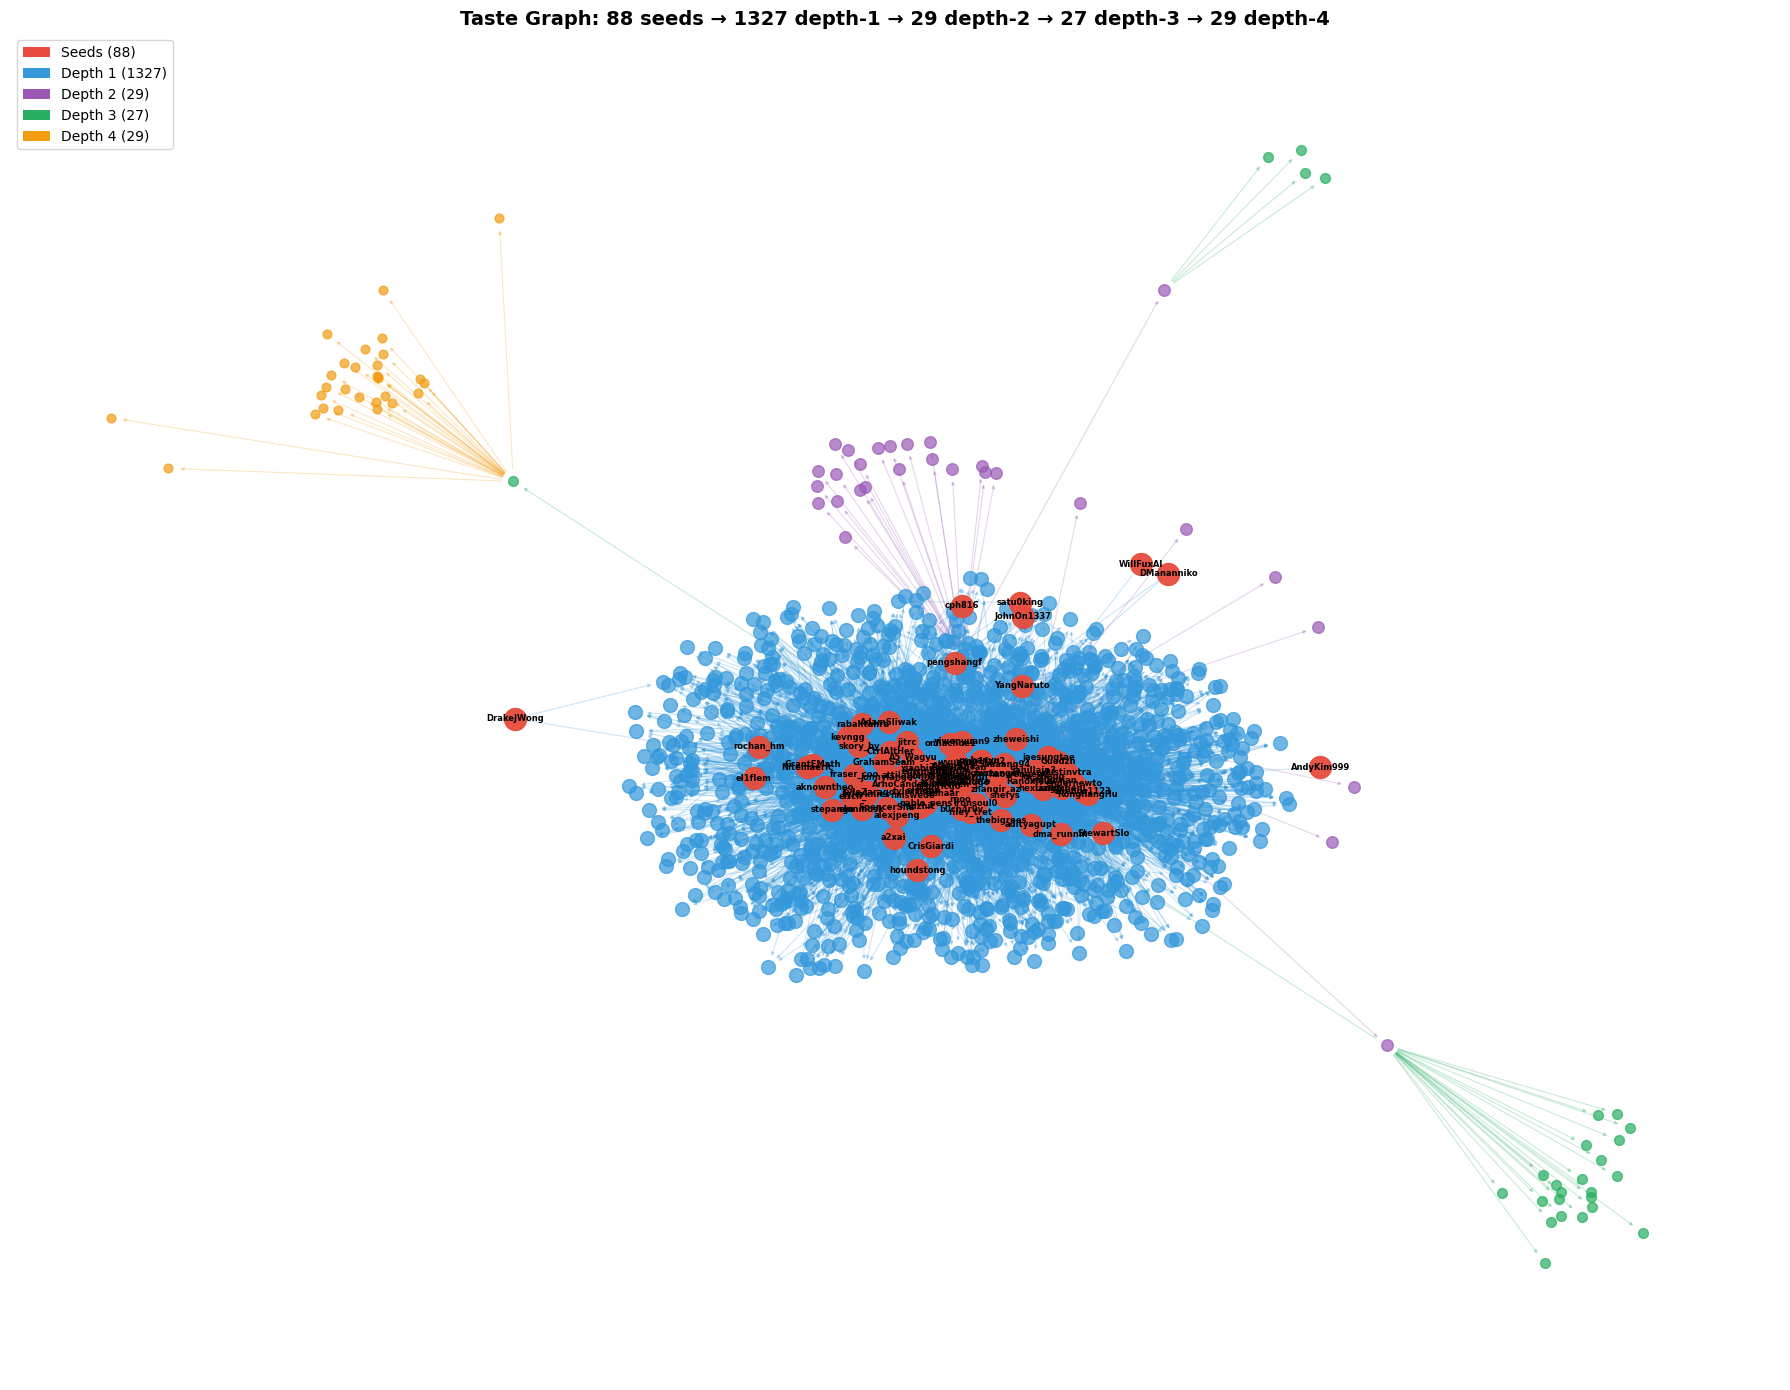


Fast LLM Screening Summary:
  Passed (engineering candidates): 2
  Failed (non-technical): 8

Passed candidates: @wmorrill3, @Mononofu


In [41]:
# Visualize graph by depth (after fast LLM screening)
print("=" * 60)
print("GRAPH VISUALIZATION (Post Fast-Screen)")
print("=" * 60)

# Show multi-depth graph
nodes_by_depth = visualize_by_depth(builder, max_nodes=1500, max_depth=5)

# Summary of LLM screening results
passed_handles = {c["handle"] for c, r in fast_screen_results if r.pass_filter}
failed_handles = {c["handle"] for c, r in fast_screen_results if not r.pass_filter}

print(f"\nFast LLM Screening Summary:")
print(f"  Passed (engineering candidates): {len(passed_handles)}")
print(f"  Failed (non-technical): {len(failed_handles)}")
print(f"\nPassed candidates: {', '.join(f'@{h}' for h in list(passed_handles)[:10])}{'...' if len(passed_handles) > 10 else ''}")

## Graph Visualization (After Fast LLM Screening)

Now visualize the graph showing:
- Which candidates passed/failed fast screening
- Depth levels (1-5 hops from seeds)
- LLM-filtered engineering candidates

## Phase 4b - Full Grok Evaluation

For candidates that pass fast screening, do full evaluation using `grok-4-1-fast-reasoning`:
- Fetch their recent tweets
- Evaluate against xAI hiring criteria
- Score and rank

In [ ]:
# Full evaluation on candidates that passed fast screen
print("=" * 60)
print("PHASE 4b: Full Grok Evaluation")
print("=" * 60)

MAX_EVAL = 10  # Limit for testing

results = evaluator.evaluate_batch(candidates, max_candidates=MAX_EVAL)

# Update nodes with evaluations
for candidate, pre_filter, evaluation in results:
    user_id = candidate.get("user_id")
    if user_id in builder.nodes:
        node = builder.nodes[user_id]
        node.grok_evaluated = True
        
        if evaluation:
            node.grok_relevant = evaluation.relevant
            node.grok_score = evaluation.score
            node.grok_reasoning = evaluation.reasoning
            node.grok_skills = ",".join(evaluation.detected_skills)
            node.grok_role = evaluation.recommended_role
            node.grok_exceptional_work = evaluation.exceptional_work
            node.grok_red_flags = ",".join(evaluation.red_flags)

In [ ]:
# Print evaluation summary
print_evaluation_summary(results)

## Phase 5 - Rank & Export

Compute underratedness scores and export results.

In [ ]:
# Compute rankings
print("=" * 60)
print("PHASE 5: Computing Rankings")
print("=" * 60)

nodes = compute_rankings(builder.nodes, builder.edges)

In [ ]:
# Export results
print("=" * 60)
print("PHASE 6: Exporting Results")
print("=" * 60)

output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

nodes_path = output_dir / "nodes.csv"
edges_path = output_dir / "edges.csv"

export_ranked_nodes(nodes, str(nodes_path))
builder.export_to_csv(str(nodes_path), str(edges_path))

print(f"\nExported to:")
print(f"  {nodes_path}")
print(f"  {edges_path}")

In [ ]:
# Final summary
print("=" * 60)
print("DISCOVERY COMPLETE")
print("=" * 60)

grok_evaluated = sum(1 for n in builder.nodes.values() if n.grok_evaluated)
grok_relevant = sum(1 for n in builder.nodes.values() if n.grok_relevant)

print(f"""
Summary:
  Total accounts discovered: {len(builder.nodes):,}
  Total interactions mapped: {len(builder.edges):,}
  Candidate accounts (follower filter): {candidate_count:,}
  Grok evaluated: {grok_evaluated}
  Grok relevant (high-quality): {grok_relevant}
""")

## View Top Candidates

In [ ]:
# Show top candidates by Grok score
relevant_nodes = [
    n for n in builder.nodes.values()
    if n.grok_relevant and n.grok_score > 0
]

relevant_nodes.sort(key=lambda n: n.grok_score, reverse=True)

print("TOP CANDIDATES BY GROK SCORE")
print("=" * 60)

for i, node in enumerate(relevant_nodes[:10], 1):
    print(f"\n{i}. @{node.handle} (score: {node.grok_score:.2f})")
    print(f"   Followers: {node.followers_count:,}")
    print(f"   Role: {node.grok_role}")
    print(f"   Skills: {node.grok_skills}")
    print(f"   Reasoning: {node.grok_reasoning[:100]}...")
    if node.grok_exceptional_work:
        print(f"   Exceptional work: {node.grok_exceptional_work[:100]}...")